In [1]:
import numpy as np
import matplotlib.pyplot as plt 

g = globals()
np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})

In [2]:
# function determining the score of a post

def score(A, U, D): #age in hours, upvotes, downvotes 
    t = A*60*60
    x = U - D
    
    if x > 0:
        y = 1
    elif x == 0:
        y = 0
    elif x < 0:
        y = -1
        
    if abs(x) >= 1:
        z = abs(x)
    elif abs(x) < 1:
        z = 1
        
    score = y * np.log10(z) - t/45000
    
    return score

In [3]:
# generate initial users and its features. Pick variables for distributions.

np.random.seed(1)
init_users = 10**4

user = np.zeros((init_users, 3)) # array filled with 3D vector for each user and its features [ [opinion, status, category], [...], [...] ]
post = np.zeros((0, 6)) # array filled with 3D vector for each post and its features [ [opinion, score, age, upvotes, downvotes, number], [...], [...] ]

for i in range(0, init_users): # create array for each user with post number that the user already has seen
     g[f'affected_{i}'] = []

opinion_sigma = 0.22 # std-deviation for users opinion gauss distr.
status_alpha = 5 # parameter for users status powerlaw distr.
cat_0_thres = 0.5 # threshold for user being in category 0
cat_1_thres = 0.9 # threshold for user being in category 1

# fill user features

for i in range(0, init_users):
    opinion = np.random.normal(0, opinion_sigma)
    #opinion = np.random.uniform(low=-1.0, high=1.0)
    status = 1-np.random.power(status_alpha)
    
    r = np.random.rand()    
    if r <= cat_0_thres:
        category = 0
    elif r <= cat_1_thres:
        category = 1
    elif r > cat_1_thres:
        category = 2
    
    user[i][0] = opinion # value from continous interval [-1,1] for opinion 1 to opinion 2
    user[i][1] = status # value from continous interval [0,1] for probabilty of being online
    user[i][2] = category # 0 for lurker(don't post/only browses hot), 1 for semi-active(posts, only browses hot), 1 for active(posts, browses new)
    
# parameter assumptions and boundary conditions

curr_users = init_users # leaving the possibilty for flexible amount of users
time = 0 # counting variable for duration of simulation
n = 0 # counting variable for amount of posts

post_thres = 0.01 # probability that a user who is online & active posts
opinion_thres = 0.2 # threshold for opinion difference for user to vote or change opinion
end_param = 50 # parameter for controlling duration of browsing
mu_1 = 0.1 # opinion reinforcement paramter
mu_2 = 0.01 # opinion rejection paramter
border = 1 # parameter for boundary conditions of the opinion model
reset = 1 # ""

In [4]:
# iteration cycle begins

simulation_time = 24 # in hours

for t in range(0, simulation_time):
    time += 1
    
    # new posts are submitted (post submitted with users opinion only when he is online & active & posts)
    
    for i in range(0, curr_users):
        r = np.random.rand()
        s = user[i][1] 
        c = user[i][2] 

        if s >= r and (c == 1 or c == 2):  
            r = np.random.rand()
            
            if r <= post_thres:
                new_post = np.array([[user[i][0], 0, 0, 1, 0, n]]) #  [[user opinion, score, duration online, upvotes, downvotes, number]]
                post = np.concatenate((post, new_post), axis=0) # add new post to array with all posts
                g[f'affected_{i}'] = np.concatenate((g[f'affected_{i}'], n), axis=None) # make sure user won't get affected by his own post again
                n += 1 
    
    # users in new upvote/novote/downvote, their opinion is changed by rejection&reinforcement
    
    post = post[np.argsort(post[:,2])] # sort post array by newest posts [newest, ..., oldest]
    
    for i in range(0, curr_users):
        r = np.random.rand()
        s = user[i][1]
        c = user[i][2] 
        
        if s >= r and c == 2: # is the user online+active? 
            endurance = int(user[i][1]*end_param) # how many posts/hour does the user see
            
            for k in range(0, endurance): # user scrolls -> deciding if vote and opinion change
                if k == n:
                    break
                
                if post[k][5] in g[f'affected_{i}']: #check if user already got affected by this post
                    continue
                else:
                    g[f'affected_{i}'] = np.concatenate((g[f'affected_{i}'], post[k][5]), axis=None) 
                
                uo = user[i][0]    
                po = post[k][0]
                opinion_diff = abs(uo - po)
                
                if opinion_diff <= opinion_thres/2:
                    post[k][3] += 1
                    
                if opinion_diff <= opinion_thres:
                    user[i][0] += mu_1 * (po - uo)
                        
                if opinion_diff > opinion_thres:
                    user[i][0] -= mu_2 * (po - uo)
                
                if opinion_diff >= opinion_thres*1.5:
                    post[k][4] += 1  
                        
                if user[i][0] > border:
                    user[i][0] = reset
                
                if user[i][0] < -border:
                    user[i][0] = -reset
    
    # score is calculated -> every post duration online increases 1h 
    for i in range(0, n):
        post[i][1] = score(post[i][2], post[i][3], post[i][4])
        post[i][2] += 1
    
    post = post[np.argsort(post[:,1])] # sort post array by hottest posts [lowest score, ..., highest score]
   
    for i in range(0, curr_users):
        r = np.random.rand()
        s = user[i][1]
        c = user[i][2] 
        
        if s >= r: # is the user online? 
            endurance = int(user[i][1]*end_param) # how many posts/hour does the user see
            
            for k in range(1, endurance): # user scrolls -> deciding if vote and opinion change
                if n-k < 0:
                    break
                    
                if post[n-k][5] in g[f'affected_{i}']: #check if user already got affected by this post
                    continue
                else:    
                    g[f'affected_{i}'] = np.concatenate((g[f'affected_{i}'], post[n-k][5]), axis=None)    
                
                uo = user[i][0]    
                po = post[n-k][0]
                opinion_diff = abs(uo - po)
                
                if opinion_diff <= opinion_thres/2:
                    post[n-k][3] += 1
                    
                if opinion_diff <= opinion_thres:
                    user[i][0] += mu_1 * (po - uo)
                        
                if opinion_diff > opinion_thres:
                    user[i][0] -= mu_2 * (po - uo)
                
                if opinion_diff >= opinion_thres*1.5:
                    post[n-k][4] += 1   
                        
                if user[i][0] > border:
                    user[i][0] = reset
                
                if user[i][0] < -border:
                    user[i][0] = -reset

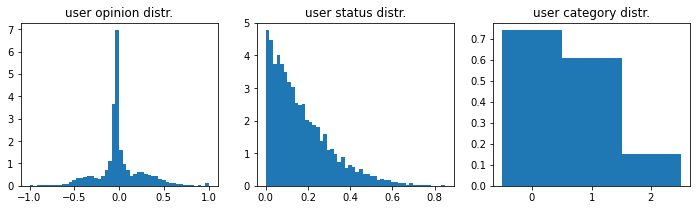

Simulation time: 24 h
Amount of users: 10000
Amount of posts: 189


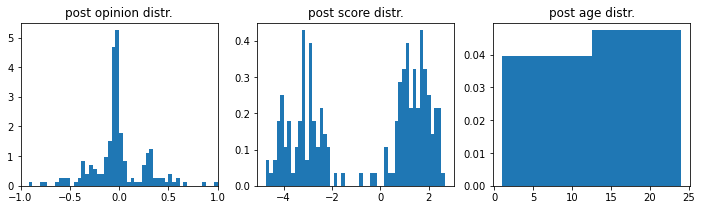

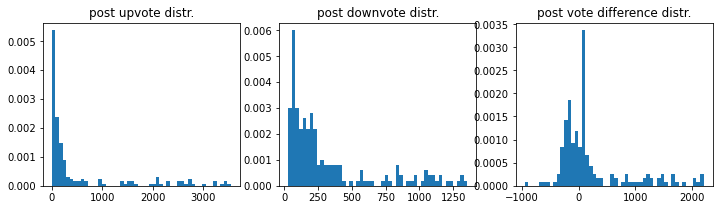

In [5]:
# plot of the current user opinion/status/category distribution

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3))
ax1.hist(user[:,0], bins=50, density='true')
ax1.set_title('user opinion distr.')
#ax1.set_xlim([-1,1])
ax2.hist(user[:,1], bins=50, density='true')
ax2.set_title('user status distr.')
ax3.hist(user[:,2], bins=3, density='true')
ax3.set_title('user category distr.')
plt.sca(ax3)
plt.xticks([0.33,1,1.66], [0,1,2])
plt.show()  

print("Simulation time: %i h" %time)
print("Amount of users:", curr_users)
print("Amount of posts:", n)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3))
ax1.hist(post[:,0], bins=50, density='true')
ax1.set_title('post opinion distr.')
ax1.set_xlim([-1,1])
ax2.hist(post[:,1], bins=50, density='true')
ax2.set_title('post score distr.')
ax3.hist(post[:,2], bins=2, density='true')
ax3.set_title('post age distr.')
plt.show()  

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3))
ax1.hist(post[:,3], bins=50, density='true')
ax1.set_title('post upvote distr.')
ax2.hist(post[:,4], bins=50, density='true')
ax2.set_title('post downvote distr.')
vote_diff = post[:,3]-post[:,4]
ax3.hist(vote_diff, bins=50, density='true')
ax3.set_title('post vote difference distr.')
plt.show()  